# Prepare "virtual" coordinate system for midrange connectivity
Requirements: <code>bluepy</code>, <code>conntility</code>

### Get locations of neurons in flat mapping coordinate system (super-sampled)
[Code provided by M. Reimann]

In [1]:
from bluepy import Circuit
from conntility.flatmapping import wm_recipe_utility
from conntility.circuit_models.neuron_groups import load_with_config

In [2]:
cfg = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig"
fn_recipe = "/gpfs/bbp.cscs.ch/project/proj83/scratch/home/reimann/rat_wm_recipe_tr_ll_ul_un_n_m_subtract_adjacents.yaml"

circ = Circuit(cfg)

# Get flat mapping coordinates for each voxel as VoxelData
atlas_out = wm_recipe_utility.atlas_of_mapping_coordinates(fn_recipe, circ, supersample=True) # Can also try =True

# Save per-voxel mapping coordinates to a .nrrd file
coord_file = "midrange_flat_mapping_coords_ss.nrrd"
atlas_out.save_nrrd(coord_file)

/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/libraries/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/py-scipy-1.5.4-t6m7lq/lib/python3.8/site-packages/scipy/spatial/transform/rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


Rotation errors: min: 0.0, median: 0.09387602600937707, mean: 0.1362824184505305, std: 0.15664142313594692, max: 2.0


In [3]:
# Configure what neuron properties to load
to_load = {
    "base_target": "All",  # adapt as needed
    "properties": ["x", "y", "z", "mtype", "layer", "region"],  # adapt as needed. Must keep x, y, z though
    "atlas": [{"data": coord_file,  # loads the mapping coords from .nrrd
               "properties": ["ss_mapping_x", "ss_mapping_y"]}]  # and calls them this
}

# Execute loading
nrn = load_with_config(circ, to_load)

# Save to .feather
nrn_file = 'neuron_info_midrange_mapping_ss.feather'
nrn.to_feather(nrn_file)

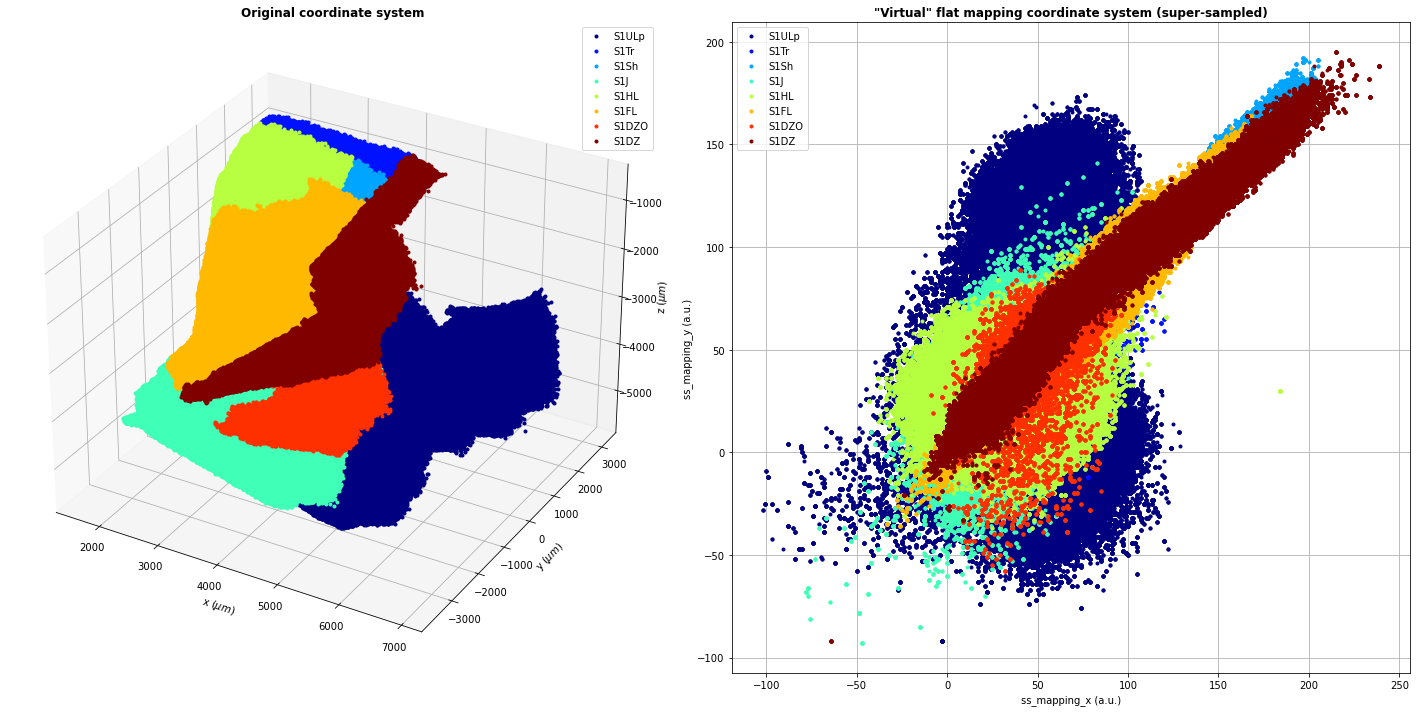

In [4]:
# Visualize flat mapping coordinate system
import numpy as np
import matplotlib.pyplot as plt
regions = np.unique(nrn['region'])
regions = regions[::-1] # Invert region order for better visualization (less overlap)
reg_colors = plt.cm.jet(np.linspace(0, 1, len(regions)))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1, projection='3d')
for ridx, reg in enumerate(regions):
    pos = nrn[nrn['region'] == reg][['x', 'y', 'z']]
    plt.plot(pos['x'], pos['y'], pos['z'], '.', color=reg_colors[ridx, :], label=reg)
plt.gca().set_xlabel('x ($\mu m$)')
plt.gca().set_ylabel('y ($\mu m$)')
plt.gca().set_zlabel('z ($\mu m$)')
plt.title('Original coordinate system', fontweight='bold')
plt.legend()
plt.subplot(1, 2, 2)
for ridx, reg in enumerate(regions):
    pos = nrn[nrn['region'] == reg][['ss_mapping_x', 'ss_mapping_y']]
    plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], '.', color=reg_colors[ridx, :], label=reg)
plt.xlabel('ss_mapping_x (a.u.)')
plt.ylabel('ss_mapping_y (a.u.)')
plt.title('"Virtual" flat mapping coordinate system (super-sampled)', fontweight='bold')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('orig_vs_virt_coords.png', dpi=300)
plt.show()

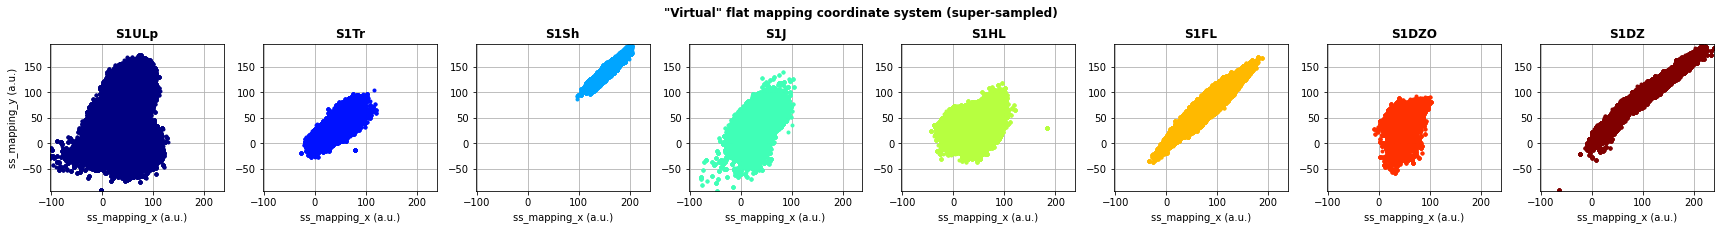

In [5]:
# Separate region plots
plt.figure(figsize=(24, 3))
x_range = [np.min(nrn['ss_mapping_x']), np.max(nrn['ss_mapping_x'])]
y_range = [np.min(nrn['ss_mapping_y']), np.max(nrn['ss_mapping_y'])]
for ridx, reg in enumerate(regions):
    plt.subplot(1, len(regions), ridx + 1)
    pos = nrn[nrn['region'] == reg][['ss_mapping_x', 'ss_mapping_y']]
    plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], '.', color=reg_colors[ridx, :], label=reg)
    plt.grid()
    plt.axis('image')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('ss_mapping_x (a.u.)')
    if ridx == 0:
        plt.ylabel('ss_mapping_y (a.u.)')
    plt.title(reg, fontweight='bold')
plt.suptitle('"Virtual" flat mapping coordinate system (super-sampled)', fontweight='bold')
plt.tight_layout()
plt.savefig('midrange_virt_coords_regions.png', dpi=300)
plt.show()

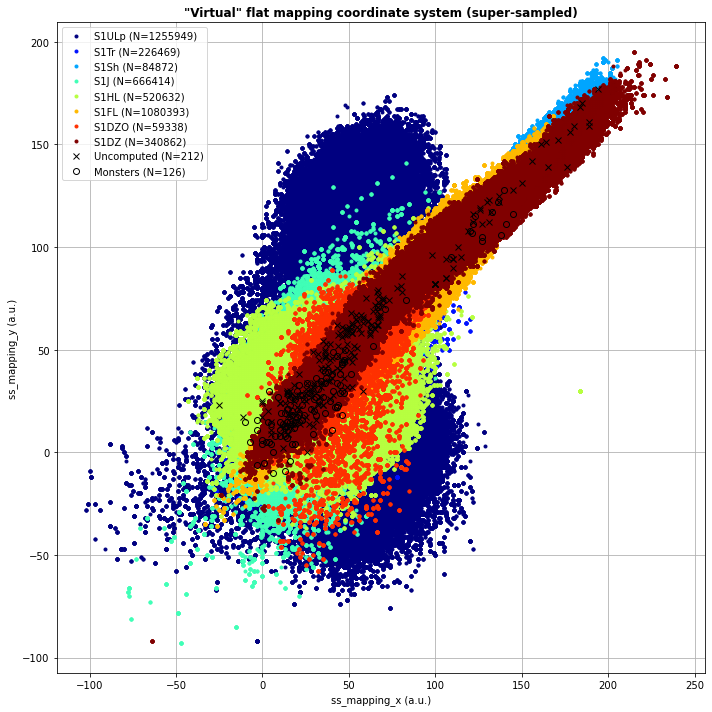

In [7]:
# Plot "virtual" midrange coordinates of uncomputed vertices & "monsters"
import pandas as pd
uncomp_gids = np.array(np.load('/gpfs/bbp.cscs.ch/project/proj102/smith/midrange/uncomputed_vertices.npy')) + 1 # ASSUMING base-0 vertex indexing
in_data = pd.read_pickle('/gpfs/bbp.cscs.ch/project/proj102/lazovski/2021-12-sscx/data/in-neighbours.pkl')
monster_gids = np.array(list(in_data.keys())) + 1 # ASSUMING base-0 monster indexing
plt.figure(figsize=(10, 10))
for ridx, reg in enumerate(regions):
    pos = nrn[nrn['region'] == reg][['ss_mapping_x', 'ss_mapping_y']]
    plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], '.', color=reg_colors[ridx, :], label=f'{reg} (N={pos.shape[0]})')
pos = nrn[np.isin(nrn['gid'], uncomp_gids)][['ss_mapping_x', 'ss_mapping_y']]
plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], 'kx', label=f'Uncomputed (N={pos.shape[0]})')
pos = nrn[np.isin(nrn['gid'], monster_gids)][['ss_mapping_x', 'ss_mapping_y']]
plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], 'ko', markerfacecolor='none', label=f'Monsters (N={pos.shape[0]})')
plt.xlabel('ss_mapping_x (a.u.)')
plt.ylabel('ss_mapping_y (a.u.)')
plt.title('"Virtual" flat mapping coordinate system (super-sampled)', fontweight='bold')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('virt_coords_monsters.png', dpi=300)
plt.show()

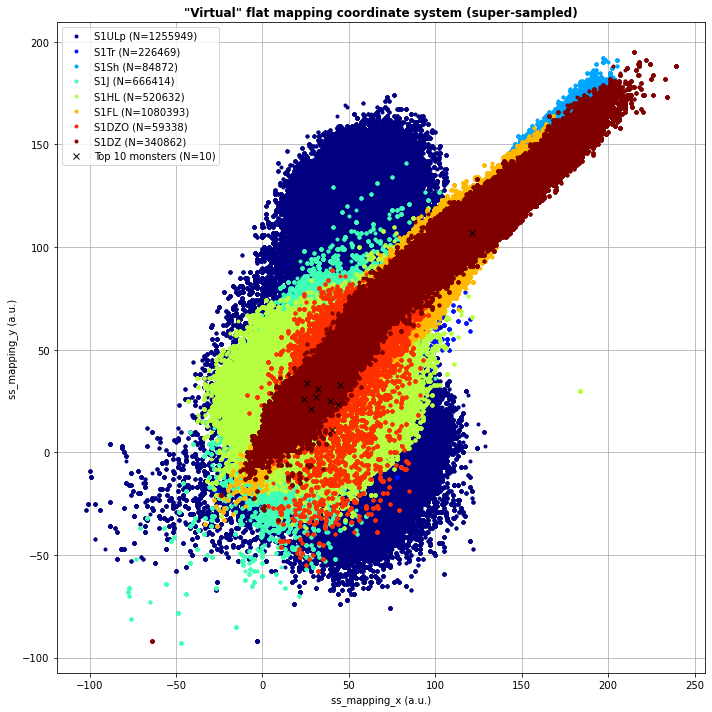

In [12]:
# Plot "virtual" midrange coordinates of top 10 "monsters"
import pandas as pd
monster_gids_top10 = np.array([3533754, 3445935, 3555052, 3556723, 3466834, 3460081, 3533126, 3544863, 3557147, 3451294]) + 1 # ASSUMING base-0 monster indexing
plt.figure(figsize=(10, 10))
for ridx, reg in enumerate(regions):
    pos = nrn[nrn['region'] == reg][['ss_mapping_x', 'ss_mapping_y']]
    plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], '.', color=reg_colors[ridx, :], label=f'{reg} (N={pos.shape[0]})')
pos = nrn[np.isin(nrn['gid'], monster_gids_top10)][['ss_mapping_x', 'ss_mapping_y']]
plt.plot(pos['ss_mapping_x'], pos['ss_mapping_y'], 'kx', markerfacecolor='none', label=f'Top 10 monsters (N={pos.shape[0]})')
plt.xlabel('ss_mapping_x (a.u.)')
plt.ylabel('ss_mapping_y (a.u.)')
plt.title('"Virtual" flat mapping coordinate system (super-sampled)', fontweight='bold')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('virt_coords_monsters_top10.png', dpi=300)
plt.show()

In [25]:
# Print top 10 monster info
nrn.loc[monster_gids_top10 - 1][['layer', 'mtype', 'region', 'gid', 'ss_mapping_x', 'ss_mapping_y']]

,layer,mtype,region,gid,ss_mapping_x,ss_mapping_y
3533754,5,L5_UPC,S1DZ,3533755,39,25
3445935,5,L5_TPC:C,S1J,3445936,31,27
3555052,5,L5_UPC,S1J,3555053,44,23
3556723,5,L5_UPC,S1J,3556724,24,26
3466834,5,L5_TPC:C,S1J,3466835,45,33
3460081,5,L5_TPC:C,S1J,3460082,40,11
3533126,5,L5_UPC,S1DZ,3533127,121,107
3544863,5,L5_UPC,S1DZ,3544864,28,21
3557147,5,L5_UPC,S1J,3557148,26,34
3451294,5,L5_TPC:C,S1J,3451295,32,31


In [47]:
# Merge virtual coordinates (and region) with existing neuron table
import os
import pandas as pd

data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
nrn_fn = 'neuron_info.feather'
nrn_merged_fn = 'neuron_info_extended.feather'

nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
common_cols = np.intersect1d(nrn_table.columns, nrn.columns)
cols_to_add = np.setdiff1d(nrn.columns, nrn_table.columns)

# Check consistency
for col in common_cols:
    assert np.all(nrn_table[col] == nrn[col]), f'ERROR: Column "{col}" mismatch!'

# Add columns
for col in cols_to_add:
    nrn_table[col] = nrn[col]

# Save to file
nrn_table.to_feather(os.path.join(data_path, nrn_merged_fn))